In [1]:
import os
from google.colab import drive

import torch
import torch.nn as nn
from typing import List
import matplotlib.pyplot as plt
import numpy as np

# Import TDA libraries
!pip install gudhi
!pip install PersistenceImages
import gudhi as gd
import PersistenceImages.persistence_images as pimg

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

import time

Using device: cuda


In [2]:
# import data

drive.mount('/content/drive')  # Simple mount point
os.chdir('/content/drive/My Drive/Deep Learning/BrainNet-Medical Imaging/src/config')

from data import data_setup, data_loader, display_sample

# import model

os.chdir('/content/drive/My Drive/Deep Learning/BrainNet-Medical Imaging/src/models')
from cnn import CNNModel

# import training methods

os.chdir('/content/drive/My Drive/Deep Learning/BrainNet-Medical Imaging/src/utils')
from training_topo import train_epoch, validate, train_model, plot_training_history

# import prediction and evaluation methods

from prediction import predict_single_image, conf_matrix, summary

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


100%|██████████| 6726/6726 [00:03<00:00, 2137.54it/s]


Unique files saved to: /tmp/unique_files/
Total files: 7023, Unique files: 6726
The following transformations are applied to the original images:
Converted to greyscale, Resized to 128x128 pixels, coverted to PyTorch tensors and pixel values normalized.
Total files in train set: 5521, with target values: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total files in test set: 1205, with target values: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

label_conversion_dict = {
            'glioma': 0,
            'meningioma': 1,
            'notumor': 2,
            'pituitary': 3,
            0: 'glioma',
            1: 'meningioma',
            2: 'notumor',
            3: 'pituitary'
        }

100%|██████████| 6726/6726 [00:03<00:00, 1934.30it/s]


Unique files saved to: /tmp/unique_files/
Total files: 7023, Unique files: 6726
The following transformations are applied to the original images:
Converted to greyscale, Resized to 128x128 pixels, coverted to PyTorch tensors and pixel values normalized.
Total files in train set: 5521, with target values: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total files in test set: 1205, with target values: ['glioma', 'meningioma', 'notumor', 'pituitary']


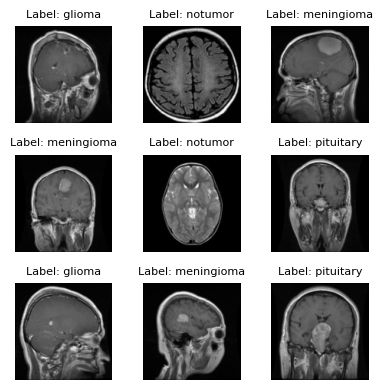

In [4]:
# Load data and data_loaders
train_set, test_set = data_setup()
train_loader, test_loader = data_loader(train_set, test_set)

# Display a sample of images from train_set
display_sample(train_set)

In [5]:
# Define the function that produces Persistent Images from images
pers_imager = pimg.PersistenceImager()

def extract_topo_features(image):
    """Input: image (1, 128, 128) tensor → Output: (5, 5) numpy array"""
    X = image.cpu().numpy().squeeze(0)
    rips = gd.RipsComplex(points = X, max_edge_length = 5)
    st = rips.create_simplex_tree(max_dimension=2)
    barcodes = st.persistence(homology_coeff_field = 2)
    barcodes_0 = st.persistence_intervals_in_dimension(0)
    barcodes_1 = st.persistence_intervals_in_dimension(1)
    pers_img_0 = pers_imager.transform(barcodes_0)
    pers_img_1 = pers_imager.transform(barcodes_1)

    return pers_img_1

In [6]:
def get_variable_name(variable, namespace):
    return [name for name, value in namespace.items() if value is variable][0]

# Usage
name = get_variable_name(train_set, globals())
print(name)

train_set


In [7]:
# Create topo_data
start_time = time.time()

# Precompute topo_features for all images
topo_data = {}

for key in {train_set, test_set}:
  var = get_variable_name(key, globals())
  var = var[:-4]
  topo_data[var] = []

  for i in range(len(key)):
      image, label = key[i]  # Get image (1, 28, 28)
      topo_features = extract_topo_features(image)  # Compute (5, 5) array
      topo_data[var].append(topo_features)

  # Convert to tensor and reshape to [N, 25] (since 5x5=25)
  topo_data[var] = torch.tensor(np.array(topo_data[var]), dtype=torch.float32).reshape(-1, 25)
  print(topo_data[var].shape)  # Should be [num_samples, 25]

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.3f} seconds")

torch.Size([5521, 25])
torch.Size([1205, 25])
Execution time: 509.045 seconds


In [8]:
from torch.utils.data import Dataset

class ImageTopoDataset(Dataset):
    def __init__(self, original_dataset, topo_data):
        self.original_dataset = original_dataset  # Your MNIST-like dataset
        self.topo_data = topo_data  # Precomputed features [N, 25]

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        return image, self.topo_data[idx], label  # (image, topo_data, label)

In [9]:
train_dataset = ImageTopoDataset(train_set, topo_data['train'])  # Wrap original dataset
test_dataset = ImageTopoDataset(test_set, topo_data['test'])

# Now each sample is (image, topo_train_data, label)
image, topo, label = train_dataset[0]
print(image.shape, topo.shape, label)

# Now each sample is (image, topo_test_data, label)
image, topo, label = test_dataset[0]
print(image.shape, topo.shape, label)

torch.Size([1, 128, 128]) torch.Size([25]) 0
torch.Size([1, 128, 128]) torch.Size([25]) 0


In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [11]:
# Write CNN Model with Persistent Images concatenated

class CNN_Topo_Model(nn.Module):
    """CNN_Topo model for brain tumor classification.

    Architecture:
        - 4 convolutional layers with LeakyReLU activation and max pooling
        - Concatenate with persistent image
        - 2 fully connected layers
        - Input shape: (batch_size, 1, 128, 128, 25)
        - Output shape: (batch_size, 4) for 4 tumor classes
    """
    def __init__(self):
        super(CNN_Topo_Model, self).__init__()

        # Conv 1: 128x128 -> 124x124 -> 62x62
        self.cnv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Conv 2: 62x62 -> 58x58 -> 29x29
        self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Conv 3: 29x29 -> 25x25 -> 12x12
        self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        # Conv 4: 12x12 -> 8x8 -> 4x4
        self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        # Activation Function
        self.leakyRelu = nn.LeakyReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4 + 25, 1024)
        self.fc2 = nn.Linear(1024, 4)  # 4 classes for tumor classification

    def forward(self, x, topo_data):
        # Layer 1
        out = self.leakyRelu(self.cnv1(x))
        out = self.maxpool1(out)

        # Layer 2
        out = self.leakyRelu(self.cnv2(out))
        out = self.maxpool2(out)

        # Layer 3
        out = self.leakyRelu(self.cnv3(out))
        out = self.maxpool3(out)

        # Layer 4
        out = self.leakyRelu(self.cnv4(out))
        out = self.maxpool4(out)

        # Flatten
        out = out.view(out.size(0), -1)

        # Concatenate topo_data
        out = torch.cat((out, topo_data), dim=1)

        # Linear layers
        out = self.leakyRelu(self.fc1(out))
        out = self.fc2(out)

        return out



In [17]:
# Train the model
start_time = time.time()

model = CNN_Topo_Model()
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=30,
    device = torch.device('cuda')
)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.3f} seconds")

Epoch: 0 Train Loss: 0.8887 Val Loss: 0.6274 Accuracy: 74.19%
Epoch: 1 Train Loss: 0.4601 Val Loss: 0.6267 Accuracy: 74.02%
Epoch: 2 Train Loss: 0.3213 Val Loss: 0.3408 Accuracy: 86.47%
Epoch: 3 Train Loss: 0.2089 Val Loss: 0.2023 Accuracy: 92.86%
Epoch: 4 Train Loss: 0.1383 Val Loss: 0.1730 Accuracy: 93.03%
Epoch: 5 Train Loss: 0.0893 Val Loss: 0.1709 Accuracy: 94.61%
Epoch: 6 Train Loss: 0.0647 Val Loss: 0.1475 Accuracy: 94.77%
Epoch: 7 Train Loss: 0.0407 Val Loss: 0.1076 Accuracy: 96.76%
Epoch: 8 Train Loss: 0.0456 Val Loss: 0.1300 Accuracy: 95.77%
Epoch: 9 Train Loss: 0.0444 Val Loss: 0.2063 Accuracy: 93.61%
Epoch: 10 Train Loss: 0.0343 Val Loss: 0.1508 Accuracy: 95.93%
Epoch: 11 Train Loss: 0.0294 Val Loss: 0.2040 Accuracy: 94.69%
Epoch: 12 Train Loss: 0.0429 Val Loss: 0.1343 Accuracy: 95.44%
Epoch: 13 Train Loss: 0.0211 Val Loss: 0.0691 Accuracy: 98.01%
Epoch: 14 Train Loss: 0.0200 Val Loss: 0.1077 Accuracy: 97.10%
Epoch: 15 Train Loss: 0.0296 Val Loss: 0.1955 Accuracy: 95.35%
Ep

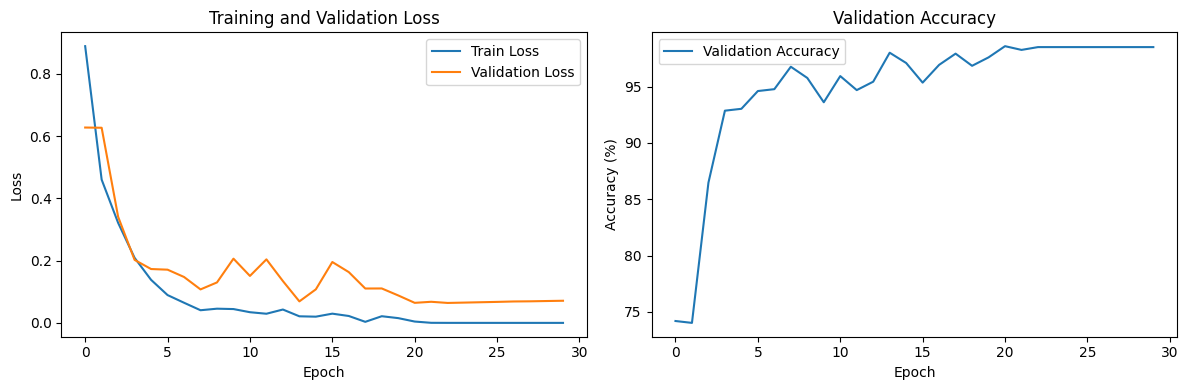

In [18]:
plot_training_history(history)

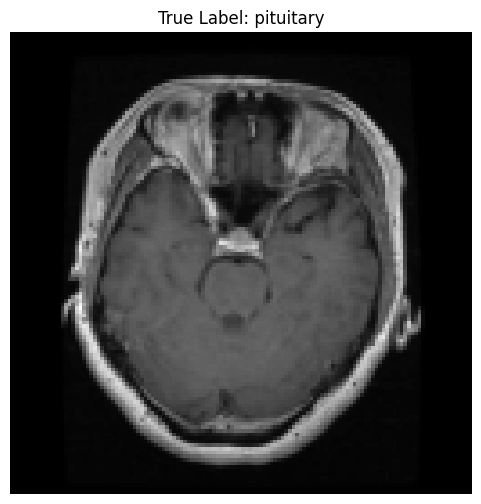

Predicted Class: pituitary


'pituitary'

In [19]:
def predict_single_image(model: nn.Module, test_set, label_conversion_dict: dict, device: torch.device) -> str:
    """
    Make prediction for a single image.

    Args:
        model: Trained PyTorch model
        test_set: Dataset containing test images
        label_conversion_dict: Dictionary mapping numeric labels to class names
        device: Device to run the model on

    Returns:
        Predicted class name
    """
    sample_idx = np.random.randint(0, len(test_set))
    image, topo, label = test_set[sample_idx]

    model.eval()
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        topo_tensor = topo.unsqueeze(0).to(device)
        output = model(image_tensor, topo_tensor)
        _, pred = torch.max(output, 1)
        predicted_class = label_conversion_dict[pred.item()]

    # Prepare image for display
    image_to_show = image.numpy().squeeze()  # Remove batch dim and convert to numpy
    if len(image_to_show.shape) == 3 and image_to_show.shape[0] == 3:  # For RGB images
        image_to_show = np.transpose(image_to_show, (1, 2, 0))

    plt.figure(figsize=(6, 6))
    plt.imshow(image_to_show, cmap='gray')
    plt.title(f'True Label: {label_conversion_dict[label]}')
    plt.axis('off')
    plt.show()
    print(f'Predicted Class: {predicted_class}')

    return predicted_class

# Example usage:
predict_single_image(model, test_dataset, label_conversion_dict, device)

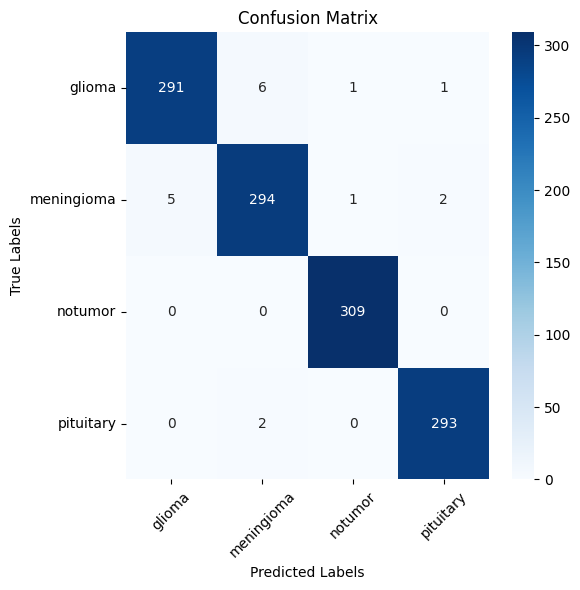

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for image, topo, label in test_dataset:
        image_tensor = image.unsqueeze(0).to(device)
        topo_tensor = topo.unsqueeze(0).to(device)
        output = model(image_tensor, topo_tensor)
        _, pred = torch.max(output, 1)

        true_labels.append(label)  # Keep as numeric
        predicted_labels.append(pred.item())  # Keep as numeric

# Convert numeric labels to class names for the confusion matrix
true_labels_names = [label_conversion_dict[l] for l in true_labels]
predicted_labels_names = [label_conversion_dict[l] for l in predicted_labels]

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_names, predicted_labels_names, labels=labels)

# Plot
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
summary(conf_matrix)

Summary: 

We have 

98.31% accuracy rate for predicting glioma.
If glioma is predicted, the true class of the predicted image could be:
meningioma with 1.69% chance
notumor with 0.00% chance
pituitary with 0.00% chance


97.35% accuracy rate for predicting meningioma.
If meningioma is predicted, the true class of the predicted image could be:
glioma with 1.99% chance
notumor with 0.00% chance
pituitary with 0.66% chance


99.36% accuracy rate for predicting notumor.
If notumor is predicted, the true class of the predicted image could be:
glioma with 0.32% chance
meningioma with 0.32% chance
pituitary with 0.00% chance


98.99% accuracy rate for predicting pituitary.
If pituitary is predicted, the true class of the predicted image could be:
glioma with 0.34% chance
meningioma with 0.68% chance
notumor with 0.00% chance


